# CS4824 Project - Meal Recommendation System
### Chloe Chappelle

Start by importing the necessary libraries.

In [9]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
random.seed(3)

Load the datasets. The program is expecting the datasets to be found in a folder in the same directory as the project named 'datasets'. The datasets can be found here: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews/

In [10]:
reviews_data = pd.read_csv("datasets/reviews.csv")
recipes_data = pd.read_csv("datasets/recipes.csv")
reviews_data = reviews_data.fillna(0)
recipes_data = recipes_data.fillna(0)

Investigate the format of the data. During the initial portions of the project, I simply loaded in the datasets and looked at the information contained in them.

In [11]:
reviews_data.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


Most of the useful information regarding ratings and users is located in the reviews dataset. However, I wanted to include some basic information from the reviews dataset and cleaned those values in the following cell.

In [12]:
recipe_data = recipes_data[["RecipeId", "RecipeCategory", "TotalTime"]].sort_values(by="RecipeId")

# function to convert the time given to a minutes format
def convert_to_minutes(duration_str):
    duration_str = duration_str[2:]
    hours_match = 0
    minutes_match = 0
    if "H" in duration_str:
        hours_match = duration_str.split("H")[0]
        if len(duration_str.split("H")) > 1:
            minutes_match = duration_str.split("H")[1][:-1]
    else:
        minutes_match = duration_str[:-1]

    # if no match found, assume 0
    hours = 0 if not hours_match else int(hours_match)
    minutes = 0 if not minutes_match else int(minutes_match)
    
    total_minutes = hours * 60 + minutes
    return total_minutes

# apply the conversion to minutes and create a numerical category column
recipe_data["TotalTime"] = recipe_data["TotalTime"].apply(convert_to_minutes)
recipe_data['category_encoded'] = pd.factorize(recipe_data['RecipeCategory'])[0]
recipe_data.head()

,RecipeId,RecipeCategory,TotalTime,category_encoded
0,38,Frozen Desserts,1485,0
1,39,Chicken Breast,265,1
2,40,Beverages,35,2
3,41,Soy/Tofu,1460,3
4,42,Vegetable,50,4


Below I create the matrix and additional arrays to prepare for matrix factorization. Because the matrix grows exponentially, I had to limit the amount of data I was working with and run on smaller samples of the intial dataset. I used a randomizer for this with a set random state.

In [13]:
# only get 50000 entries due to the large size of the dataset and creating a matrix out the data
data = reviews_data.sample(n=10000, random_state=4).sort_values(by="RecipeId")
# create the matrix
test = data.pivot_table(index="AuthorId", columns="RecipeId", values="Rating", fill_value=0).to_numpy()
# create the arrays for additional parameters later on
recipe_categories = recipe_data.sample(n=10000, random_state=4)["category_encoded"].to_numpy()
cook_time = recipe_data.sample(n=10000, random_state=4)["TotalTime"].to_numpy()

Below is the matrix factorization algorithm. Inspiration was taken from the following article: https://medium.com/@rebirth4vali/implementing-matrix-factorization-technique-for-recommender-systems-from-scratch-7828c9166d3c

In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

class MatrixFactorization():
    def __init__(self, train_matrix, test_matrix=None, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100, threshold=4):
        self.train_matrix = train_matrix
        self.test_matrix = test_matrix
        self.n_users, self.n_items = train_matrix.shape
        self.non_zero_row_ind, self.non_zero_col_ind = train_matrix.nonzero()
        self.n_interac = len(train_matrix[np.where(train_matrix != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate
        self.alpha = alpha
        self.n_iter = n_iter
        self.rmse_lst = []
        self.mae_lst = [] 
        self.precision_lst = [] 
        self.recall_lst = [] 
        self.test_rmse_lst = []
        self.test_mae_lst = []
        self.test_precision_lst = []
        self.test_recall_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False
        self.threshold = threshold  # threshold for determining precision and recall values

    # random initialize of starting weights
    def initialize(self):
        self.now = time.time()
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        self.global_bias = np.mean(self.train_matrix[np.where(self.train_matrix != 0)])  # Use train_matrix here
        self.evaluate_the_model(0)

    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + self.user_vecs[u] @ self.item_vecs[i]

    def update_biases_and_vectors(self, error, u, i):
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        tot_absolute_error = 0
        true_labels = []  # For precision and recall calculation
        predicted_labels = []

        for index in self.ind_lst:
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            actual_rating = self.train_matrix[u, i]

            tot_square_error += (actual_rating - pred_rat) ** 2
            tot_absolute_error += abs(actual_rating - pred_rat)
            true_labels.append(1 if actual_rating >= self.threshold else 0)
            predicted_labels.append(1 if pred_rat >= self.threshold else 0)

        rmse = np.sqrt(tot_square_error / self.n_interac)
        mae = tot_absolute_error / self.n_interac
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)

        self.rmse_lst.append(rmse)
        self.mae_lst.append(mae)
        self.precision_lst.append(precision)
        self.recall_lst.append(recall)

        # ff test_matrix is available, evaluate test data
        if self.test_matrix is not None:
            self.evaluate_on_test_data()

        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"RMSE: {np.round(self.rmse_lst[-1], 3)} | MAE: {np.round(self.mae_lst[-1], 3)} | "
                  f"Precision: {np.round(self.precision_lst[-1], 3)} | Recall: {np.round(self.recall_lst[-1], 3)} "
                  f"=== Total training time: {temp} seconds.")

    def evaluate_on_test_data(self):
        tot_square_error = 0
        tot_absolute_error = 0
        true_labels = []
        predicted_labels = []

        for u in range(self.test_matrix.shape[0]):
            for i in range(self.test_matrix.shape[1]):
                if self.test_matrix[u, i] != 0:
                    pred_rat = self.predict(u, i)
                    actual_rating = self.test_matrix[u, i]
                    
                    tot_square_error += (actual_rating - pred_rat) ** 2
                    tot_absolute_error += abs(actual_rating - pred_rat)
                    true_labels.append(1 if actual_rating >= self.threshold else 0)
                    predicted_labels.append(1 if pred_rat >= self.threshold else 0)

        rmse = np.sqrt(tot_square_error / len(self.test_matrix[np.where(self.test_matrix != 0)]))
        mae = tot_absolute_error / np.count_nonzero(self.test_matrix)
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)

        self.test_rmse_lst.append(rmse)
        self.test_mae_lst.append(mae)
        self.test_precision_lst.append(precision)
        self.test_recall_lst.append(recall)

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    
                    # Change this line to use train_matrix instead of ratings
                    error = self.train_matrix[u, i] - pred_rat  # Use train_matrix here

                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.conv_epoch_num = self.conv_epoch_num if self.stop else self.n_iter
        self.plot_the_score()

    def plot_the_score(self):
        # Plot RMSE, MAE, precision, and recall over epochs for both train and test data
        plt.figure(figsize=(18, 6))

        # RMSE
        plt.subplot(2, 2, 1)
        plt.plot(range(1, 1 + len(self.rmse_lst)), self.rmse_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_rmse_lst)), self.test_rmse_lst, marker='x', label='Test', linestyle='--')
        plt.title("RMSE vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend()

        # MAE
        plt.subplot(2, 2, 2)
        plt.plot(range(1, 1 + len(self.mae_lst)), self.mae_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_mae_lst)), self.test_mae_lst, marker='x', label='Test', linestyle='--')
        plt.title("MAE vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()

        # Precision
        plt.subplot(2, 2, 3)
        plt.plot(range(1, 1 + len(self.precision_lst)), self.precision_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_precision_lst)), self.test_precision_lst, marker='x', label='Test', linestyle='--')
        plt.title("Precision vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

        # Recall
        plt.subplot(2, 2, 4)
        plt.plot(range(1, 1 + len(self.recall_lst)), self.recall_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_recall_lst)), self.test_recall_lst, marker='x', label='Test', linestyle='--')
        plt.title("Recall vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()


---> Epoch 0
RMSE: 0.744 | MAE: 0.532 | Precision: 0.934 | Recall: 1.0 === Total training time: 1.257 seconds.
---> Epoch 1
RMSE: 0.726 | MAE: 0.515 | Precision: 0.934 | Recall: 1.0 === Total training time: 2.438 seconds.
---> Epoch 2
RMSE: 0.71 | MAE: 0.501 | Precision: 0.934 | Recall: 1.0 === Total training time: 3.626 seconds.
---> Epoch 3
RMSE: 0.695 | MAE: 0.488 | Precision: 0.934 | Recall: 1.0 === Total training time: 4.841 seconds.
---> Epoch 4
RMSE: 0.681 | MAE: 0.476 | Precision: 0.934 | Recall: 1.0 === Total training time: 6.077 seconds.
---> Epoch 5
RMSE: 0.667 | MAE: 0.465 | Precision: 0.934 | Recall: 1.0 === Total training time: 7.257 seconds.
---> Epoch 6
RMSE: 0.654 | MAE: 0.455 | Precision: 0.934 | Recall: 1.0 === Total training time: 8.488 seconds.
---> Epoch 7
RMSE: 0.641 | MAE: 0.444 | Precision: 0.934 | Recall: 1.0 === Total training time: 9.675 seconds.
---> Epoch 8
RMSE: 0.629 | MAE: 0.435 | Precision: 0.934 | Recall: 1.0 === Total training time: 10.899 seconds.
-

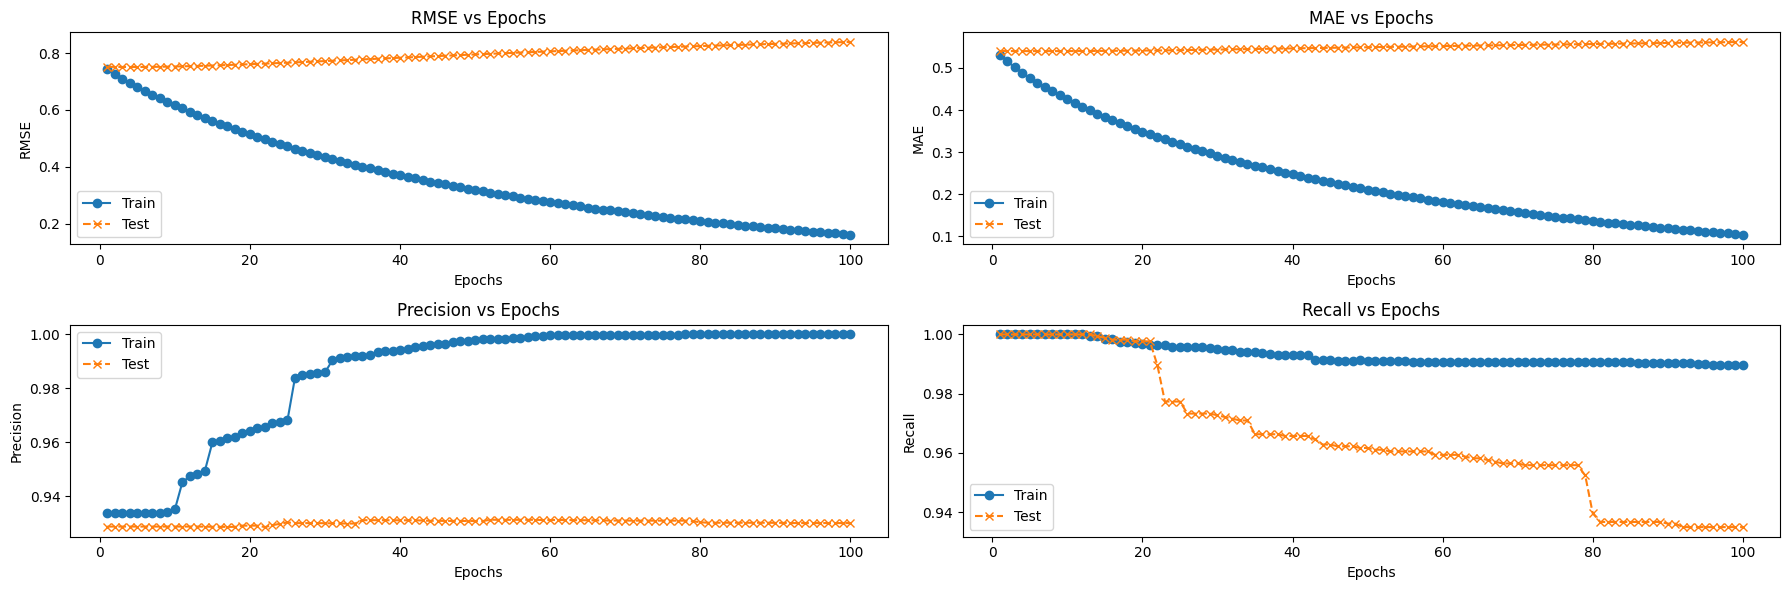

In [15]:
# Split the data into train and test
train_matrix, test_matrix = train_test_split(test, test_size=0.2, random_state=4)

# Initialize the matrix factorization model with both train and test matrices
mf_model = MatrixFactorization(train_matrix, test_matrix)

# Train the model
mf_model.fit()


Using the same model as above, the training is re-run with a filtered dataset using the categories and values from the recipe dataset. For this specific example, the dataset is filtered to include only recipes that take less than an hour and are in the Vegetables category. This is to demonstrate how specify certain input parameters can effect the model in terms of its various evaluation metrics.

In [16]:
# filter the data to include only recipes that take less than an hour (60 minutes) and are in the Vegetables category
merged_data = reviews_data.merge(recipe_data[['RecipeId', 'RecipeCategory', 'TotalTime']], on='RecipeId', how='inner')

# filter for recipes in 'Vegetable' category and cook time less than 60 minutes
filtered_data = merged_data[(merged_data['RecipeCategory'] == 'Vegetable') & (merged_data['TotalTime'] < 60)]

# create the matrix like before
filtered_data = filtered_data.sample(n=50000, random_state=4).sort_values(by="RecipeId")
filtered_matrix = filtered_data.pivot_table(index="AuthorId", columns="RecipeId", values="Rating", fill_value=0).to_numpy()

---> Epoch 0
RMSE: 0.646 | MAE: 0.472 | Precision: 0.95 | Recall: 1.0 === Total training time: 4.271 seconds.
---> Epoch 1
RMSE: 0.618 | MAE: 0.429 | Precision: 0.95 | Recall: 1.0 === Total training time: 8.488 seconds.
---> Epoch 2
RMSE: 0.602 | MAE: 0.411 | Precision: 0.951 | Recall: 0.999 === Total training time: 12.755 seconds.
---> Epoch 3
RMSE: 0.59 | MAE: 0.399 | Precision: 0.951 | Recall: 0.999 === Total training time: 17.405 seconds.
---> Epoch 4
RMSE: 0.579 | MAE: 0.39 | Precision: 0.952 | Recall: 0.998 === Total training time: 22.081 seconds.
---> Epoch 5
RMSE: 0.57 | MAE: 0.382 | Precision: 0.952 | Recall: 0.997 === Total training time: 26.671 seconds.
---> Epoch 6
RMSE: 0.561 | MAE: 0.375 | Precision: 0.953 | Recall: 0.997 === Total training time: 31.004 seconds.
---> Epoch 7
RMSE: 0.554 | MAE: 0.369 | Precision: 0.953 | Recall: 0.997 === Total training time: 35.427 seconds.
---> Epoch 8
RMSE: 0.547 | MAE: 0.363 | Precision: 0.954 | Recall: 0.996 === Total training time: 3

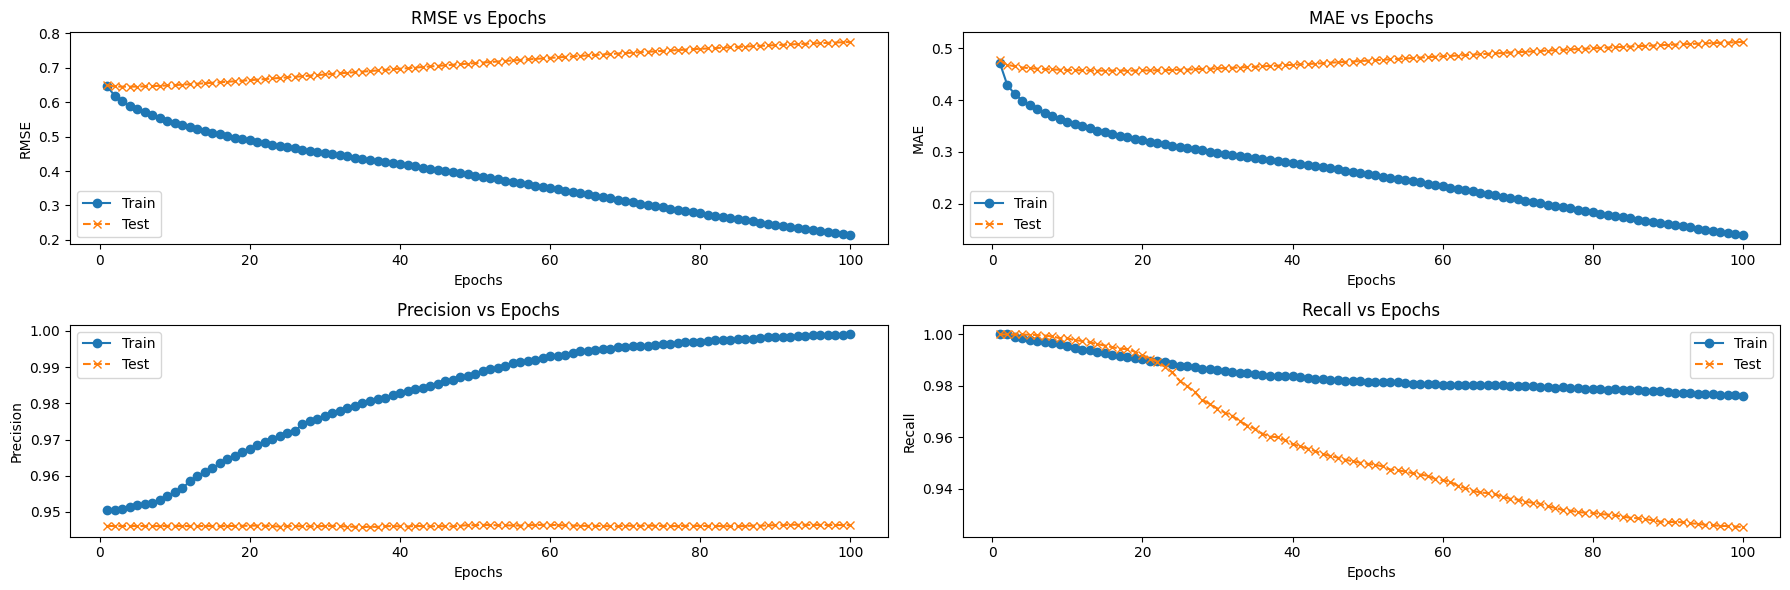

In [17]:
train_filtered_matrix, test_filtered_matrix = train_test_split(filtered_matrix, test_size=0.2, random_state=4)
mf_filtered_model = MatrixFactorization(train_filtered_matrix, test_filtered_matrix)
mf_filtered_model.fit()

Lastly, the model is adjusted to include the recipe and category parameters internally as additional features. This model runs as a subclass of the previous Matrix Factorization class, since it shares many similarities with the previous model.

In [ ]:
class MFAddFeatures(MatrixFactorization):
    
    def __init__(self, ratings, cook_time, category_encoded, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100, threshold=4, test_size=0.2):
        # split data into training and testing
        self.test_size = test_size
        self.ratings = ratings
        self.cook_time = cook_time
        self.category_encoded = category_encoded
        
        # split matrix into testing and training
        self.train_matrix, self.test_matrix = train_test_split(ratings, test_size=test_size, random_state=4)

        # call the parent class constructor
        super().__init__(self.train_matrix, self.test_matrix, n_factors=n_factors, l_rate=l_rate, alpha=alpha, n_iter=n_iter, threshold=threshold)
        
        # Add two for the two additional features: cook_time and category
        self.n_features = n_factors + 2

    def initialize(self):
        self.recipe_cook_time = np.random.normal(scale=1/self.n_factors, size=(self.n_items, 1))
        self.recipe_category = np.random.normal(scale=1/self.n_factors, size=(self.n_items, 1))
        super().initialize()

    def predict(self, u, i):
        cook_time_feature = self.recipe_cook_time[i]
        category_feature = self.recipe_category[i]
        
        # add cook time and category to the prediction - sum user weights and multiply by feature
        prediction = (self.global_bias + self.user_biases[u] + self.item_biases[i] + 
                    np.dot(self.user_vecs[u], self.item_vecs[i]) + 
                    cook_time_feature * np.dot(self.user_vecs[u], np.ones_like(self.user_vecs[u])) + 
                    category_feature * np.dot(self.user_vecs[u], np.ones_like(self.user_vecs[u])))
        return prediction

    def update_biases_and_vectors(self, error, u, i):
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])
        # add updates for additional features
        self.recipe_cook_time[i] += self.l_rate * (error * self.user_vecs[u, :].sum() - self.alpha * self.recipe_cook_time[i])
        self.recipe_category[i] += self.l_rate * (error * self.user_vecs[u, :].sum() - self.alpha * self.recipe_category[i])

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)[0]
                    error = self.train_matrix[u, i] - pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.conv_epoch_num = self.conv_epoch_num if self.stop else self.n_iter
        self.plot_the_score()

    def plot_the_score(self):
        # plot RMSE, MAE, precision, and recall over epochs for both train and test data
        plt.figure(figsize=(18, 6))

        # RMSE
        plt.subplot(2, 2, 1)
        plt.plot(range(1, 1 + len(self.rmse_lst)), self.rmse_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_rmse_lst)), self.test_rmse_lst, marker='x', label='Test', linestyle='--')
        plt.title("RMSE vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.legend()

        # MAE
        plt.subplot(2, 2, 2)
        plt.plot(range(1, 1 + len(self.mae_lst)), self.mae_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_mae_lst)), self.test_mae_lst, marker='x', label='Test', linestyle='--')
        plt.title("MAE vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()

        # precision
        plt.subplot(2, 2, 3)
        plt.plot(range(1, 1 + len(self.precision_lst)), self.precision_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_precision_lst)), self.test_precision_lst, marker='x', label='Test', linestyle='--')
        plt.title("Precision vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

        # recall
        plt.subplot(2, 2, 4)
        plt.plot(range(1, 1 + len(self.recall_lst)), self.recall_lst, marker='o', label='Train')
        if self.test_matrix is not None:
            plt.plot(range(1, 1 + len(self.test_recall_lst)), self.test_recall_lst, marker='x', label='Test', linestyle='--')
        plt.title("Recall vs Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()


---> Epoch 0
RMSE: [0.744] | MAE: [0.532] | Precision: 0.934 | Recall: 1.0 === Total training time: 1.424 seconds.
---> Epoch 1
RMSE: [0.726] | MAE: [0.515] | Precision: 0.934 | Recall: 1.0 === Total training time: 2.917 seconds.
---> Epoch 2
RMSE: [0.71] | MAE: [0.501] | Precision: 0.934 | Recall: 1.0 === Total training time: 4.4 seconds.
---> Epoch 3
RMSE: [0.695] | MAE: [0.488] | Precision: 0.934 | Recall: 1.0 === Total training time: 5.96 seconds.
---> Epoch 4
RMSE: [0.68] | MAE: [0.476] | Precision: 0.934 | Recall: 1.0 === Total training time: 7.487 seconds.
---> Epoch 5
RMSE: [0.666] | MAE: [0.465] | Precision: 0.934 | Recall: 1.0 === Total training time: 8.966 seconds.
---> Epoch 6
RMSE: [0.653] | MAE: [0.454] | Precision: 0.934 | Recall: 1.0 === Total training time: 12.572 seconds.
---> Epoch 7
RMSE: [0.64] | MAE: [0.444] | Precision: 0.934 | Recall: 1.0 === Total training time: 15.998 seconds.
---> Epoch 8
RMSE: [0.628] | MAE: [0.434] | Precision: 0.934 | Recall: 1.0 === Total

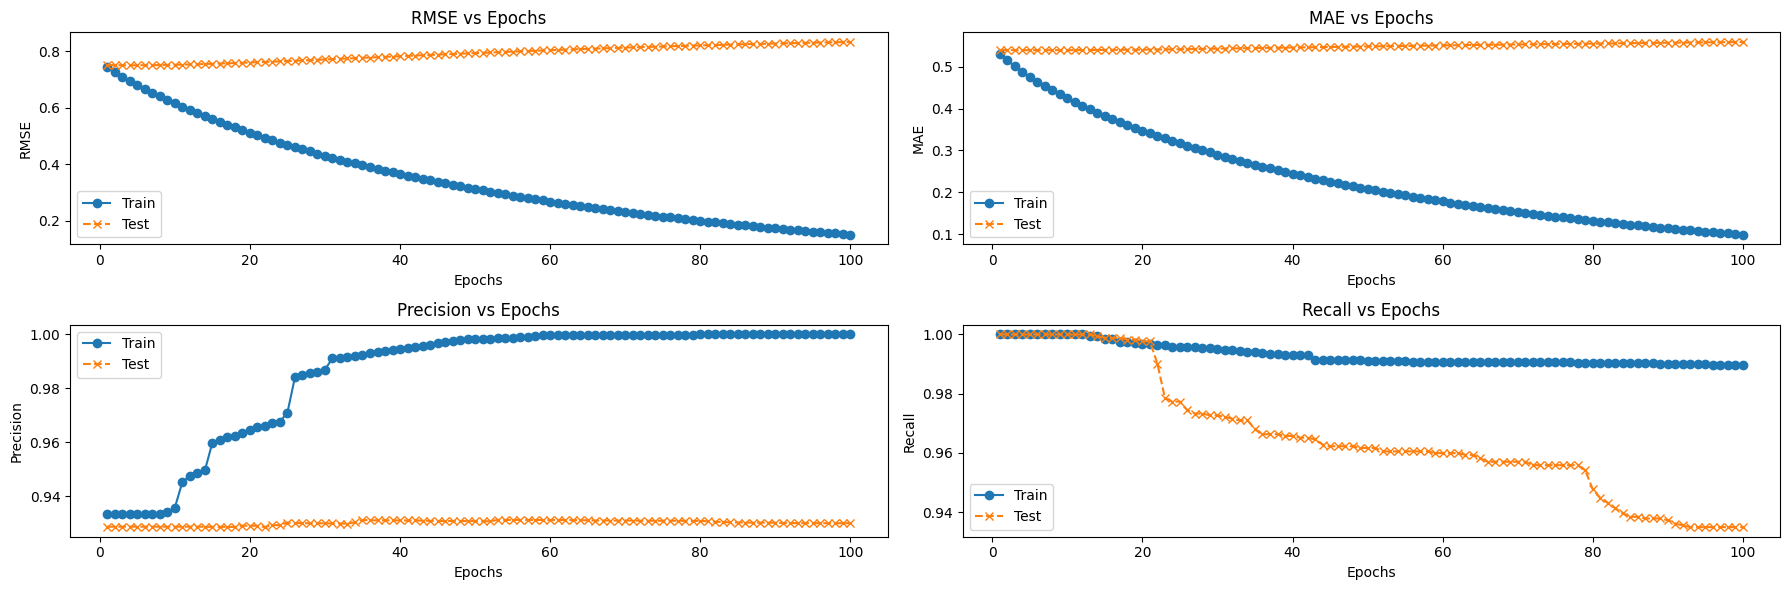

In [22]:
mf_features_model = MFAddFeatures(test, cook_time, recipe_categories)
mf_features_model.fit()

Finally, for curiosity and completeness, the filtered dataset is run using the model incoporating the features.

---> Epoch 0
RMSE: [0.646] | MAE: [0.472] | Precision: 0.95 | Recall: 1.0 === Total training time: 5.242 seconds.
---> Epoch 1
RMSE: [0.618] | MAE: [0.428] | Precision: 0.95 | Recall: 1.0 === Total training time: 10.744 seconds.
---> Epoch 2
RMSE: [0.602] | MAE: [0.411] | Precision: 0.951 | Recall: 0.999 === Total training time: 16.21 seconds.
---> Epoch 3
RMSE: [0.589] | MAE: [0.398] | Precision: 0.951 | Recall: 0.999 === Total training time: 21.498 seconds.
---> Epoch 4
RMSE: [0.579] | MAE: [0.389] | Precision: 0.952 | Recall: 0.998 === Total training time: 26.939 seconds.
---> Epoch 5
RMSE: [0.569] | MAE: [0.381] | Precision: 0.952 | Recall: 0.997 === Total training time: 32.308 seconds.
---> Epoch 6
RMSE: [0.561] | MAE: [0.374] | Precision: 0.953 | Recall: 0.997 === Total training time: 37.799 seconds.
---> Epoch 7
RMSE: [0.553] | MAE: [0.367] | Precision: 0.953 | Recall: 0.996 === Total training time: 43.35 seconds.
---> Epoch 8
RMSE: [0.546] | MAE: [0.363] | Precision: 0.954 | Re

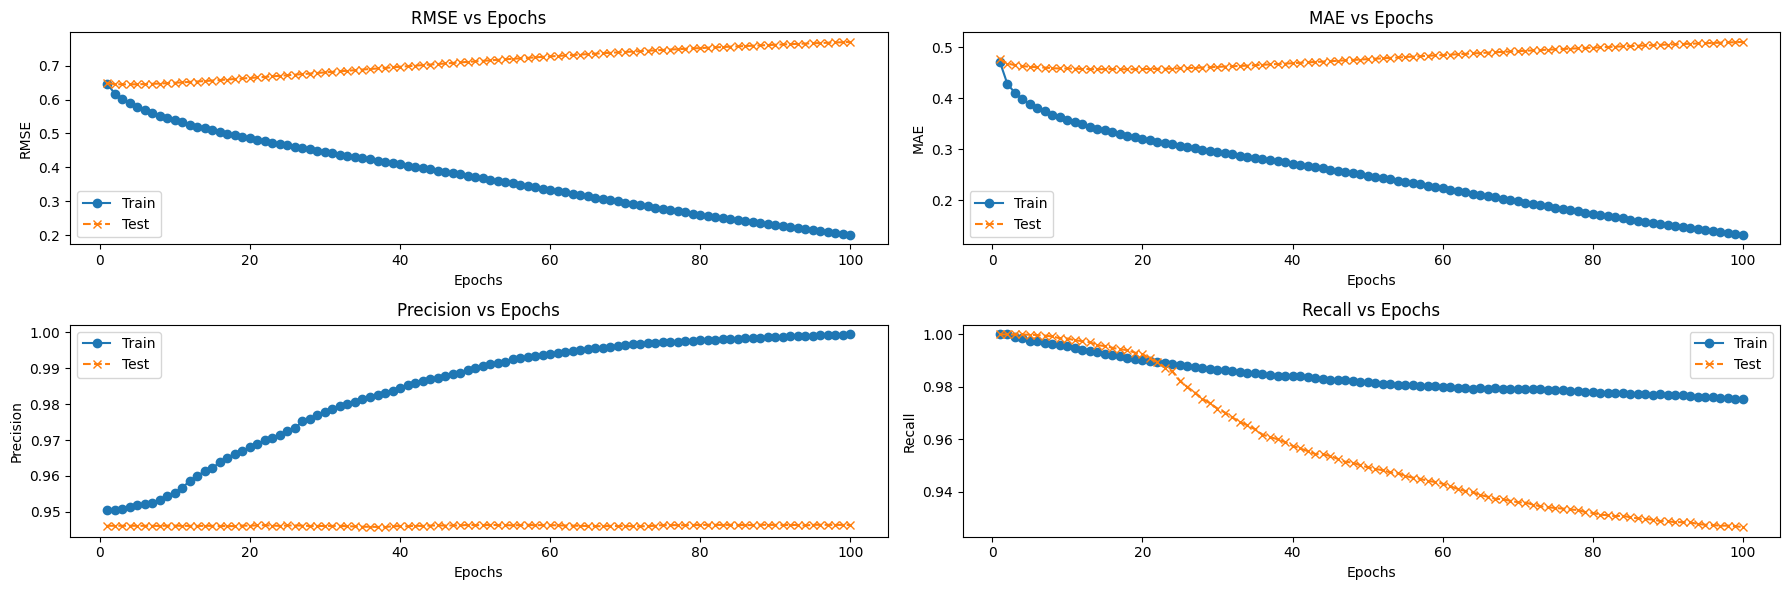

In [23]:
mf_features_filtered_model = MFAddFeatures(filtered_matrix, cook_time, recipe_categories)
mf_features_filtered_model.fit()